**Write a function that takes N as an input and returns the matrix A and the vector b**

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.sparse.linalg import spsolve
from scipy.optimize import curve_fit
from petsc4py import PETSc
import time

# ---------- Part1 ----------

# function g
def g(x, y):
    if x == 0:
        return np.sin(4 * y)
    if y == 0:
        return np.sin(3 * x)
    if x == 1:
        return np.sin(3 + 4 * y)
    if y == 1:
        return np.sin(3 * x + 4)


# Get sparse matrix A and vector b, the input N should be an integer greater than 1
# For the acquisition of sparse matrix A and vector b, I only use one for loop, so that this function can carry a larger N and reduce the running time
def helmholtz_wave(N):
    k = 5
    h = 1 / N
    # elements of data is equal to four corner * 4 + boundary elements * 6 + inner elements * 9
    nelements = 4 * 4 + 9 * (N - 3) ** 2 + 6 * ((N - 1) ** 2 - (N - 3) ** 2 - 4)

    row_ind = np.zeros(nelements)
    col_ind = np.zeros(nelements)
    data = np.zeros(nelements)
    b = np.zeros((N - 1) ** 2)
    count = 0
    for i in range((N - 1) ** 2):
        # Lower boundary
        if i // (N - 1) == 0:
            # Lower left corner
            if i % (N - 1) == 0:
                # consider the situation when N = 2
                if nelements == 1:
                    row_ind[count] = i
                    col_ind[count] = i
                    data[count] = (24 - 4 * h ** 2 * k ** 2) / 9
                    b[i] = ((12 + (h ** 2) * (k ** 2)) / 36) * (
                            g(0, 0) + g(2 * h, 0) + g(0, 2 * h) + g(2 * h, 2 * h)) + (
                                   (3 + (h ** 2) * (k ** 2)) / 9) * (g(h, 0) + g(0, h) + g(h, 1) + g(1, h))
                else:
                    row_ind[count:count + 4] = i
                    col_ind[count] = i
                    col_ind[count + 1] = i + 1
                    col_ind[count + 2] = i + N - 1
                    col_ind[count + 3] = i + N
                    data[count] = (24 - 4 * h ** 2 * k ** 2) / 9
                    data[count + 1] = data[count + 2] = (-3 - h ** 2 * k ** 2) / 9
                    data[count + 3] = (-12 - h ** 2 * k ** 2) / 36
                    count = count + 4
                    b[i] = (12 + h ** 2 * k ** 2) / 36 * (g(0, 0) + g(2 * h, 0) + g(0, 2 * h)) + (
                            3 + h ** 2 * k ** 2) / 9 * (g(h, 0) + g(0, h))
            # Lower right corner
            elif (i + 1) % (N - 1) == 0:
                row_ind[count:count + 4] = i
                col_ind[count] = i - 1
                col_ind[count + 1] = i
                col_ind[count + 2] = i + N - 2
                col_ind[count + 3] = i + N - 1
                data[count + 1] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count] = data[count + 3] = (-3 - h ** 2 * k ** 2) / 9
                data[count + 2] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 4
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g(1, 0) + g(1, 2 * h) + g(1 - 2 * h, 0)) + (
                        3 + h ** 2 * k ** 2) / 9 * (g(1 - h, 0) + g(1, h))
            # Lower boundary elements except corner
            else:
                row_ind[count:count + 6] = i
                col_ind[count] = i - 1
                col_ind[count + 1] = i
                col_ind[count + 2] = i + 1
                col_ind[count + 3] = i + N - 2
                col_ind[count + 4] = i + N - 1
                col_ind[count + 5] = i + N
                data[count + 1] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count] = data[count + 2] = data[count + 4] = (-3 - h ** 2 * k ** 2) / 9
                data[count + 3] = data[count + 5] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 6
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g((i + 1) * h + h, 0) + g((i + 1) * h - h, 0)) + (
                        3 + h ** 2 * k ** 2) / 9 * g((i + 1) * h, 0)
        # Upper boundary
        elif i // (N - 1) == N - 2:
            # Top left corner
            if i % (N - 1) == 0:
                row_ind[count:count + 4] = i
                col_ind[count] = i - N + 1
                col_ind[count + 1] = i - N + 2
                col_ind[count + 2] = i
                col_ind[count + 3] = i + 1
                data[count + 2] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count] = data[count + 3] = (-3 - h ** 2 * k ** 2) / 9
                data[count + 1] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 4
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g(0, 1) + g(2 * h, 1) + g(0, 1 - 2 * h)) + (
                        3 + h ** 2 * k ** 2) / 9 * (g(h, 1) + g(0, 1 - h))
            # Top right corner
            elif (i + 1) % (N - 1) == 0:
                row_ind[count:count + 4] = i
                col_ind[count] = i - N
                col_ind[count + 1] = i - N + 1
                col_ind[count + 2] = i - 1
                col_ind[count + 3] = i
                data[count + 3] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count + 1] = data[count + 2] = (-3 - h ** 2 * k ** 2) / 9
                data[count] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 4
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g(1, 1) + g(1 - 2 * h, 1) + g(1, 1 - 2 * h)) + (
                        3 + h ** 2 * k ** 2) / 9 * (g(1 - h, 1) + g(1, 1 - h))
            # Upper boundary elements except corner
            else:
                row_ind[count:count + 6] = i
                col_ind[count] = i - N
                col_ind[count + 1] = i - N + 1
                col_ind[count + 2] = i - N + 2
                col_ind[count + 3] = i - 1
                col_ind[count + 4] = i
                col_ind[count + 5] = i + 1
                data[count + 4] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count + 1] = data[count + 3] = data[count + 5] = (-3 - h ** 2 * k ** 2) / 9
                data[count] = data[count + 2] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 6
                p = i % (N - 1)
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g((p + 1) * h + h, 1) + g((p + 1) * h - h, 1)) + (
                        3 + h ** 2 * k ** 2) / 9 * g((p + 1) * h, 1)
        # Elements that are not on the top and bottom boundaries
        else:
            # Left boundary elements except corner
            if i % (N - 1) == 0:
                row_ind[count:count + 6] = i
                col_ind[count] = i - N + 1
                col_ind[count + 1] = i - N + 2
                col_ind[count + 2] = i
                col_ind[count + 3] = i + 1
                col_ind[count + 4] = i + N - 1
                col_ind[count + 5] = i + N
                data[count + 2] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count] = data[count + 3] = data[count + 4] = (-3 - h ** 2 * k ** 2) / 9
                data[count + 1] = data[count + 5] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 6
                p = i // (N - 1)
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g(0, (p + 1) * h + h) + g(0, (p + 1) * h - h)) + (
                        3 + h ** 2 * k ** 2) / 9 * g(0, (p + 1) * h)
            # Right boundary elements except corner
            elif (i + 1) % (N - 1) == 0:
                row_ind[count:count + 6] = i
                col_ind[count] = i - N
                col_ind[count + 1] = i - N + 1
                col_ind[count + 2] = i - 1
                col_ind[count + 3] = i
                col_ind[count + 4] = i + N - 2
                col_ind[count + 5] = i + N - 1
                data[count + 3] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count + 1] = data[count + 2] = data[count + 5] = (-3 - h ** 2 * k ** 2) / 9
                data[count] = data[count + 4] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 6
                p = (i + 1) // (N - 1)
                b[i] = (12 + h ** 2 * k ** 2) / 36 * (g(1, p * h + h) + g(1, p * h - h)) + (
                        3 + h ** 2 * k ** 2) / 9 * g(1, p * h)
            # inner elements
            else:
                row_ind[count:count + 9] = i
                col_ind[count] = i - N
                col_ind[count + 1] = i - N + 1
                col_ind[count + 2] = i - N + 2
                col_ind[count + 3] = i - 1
                col_ind[count + 4] = i
                col_ind[count + 5] = i + 1
                col_ind[count + 6] = i + N - 2
                col_ind[count + 7] = i + N - 1
                col_ind[count + 8] = i + N
                data[count + 4] = (24 - 4 * h ** 2 * k ** 2) / 9
                data[count + 1] = data[count + 3] = data[count + 5] = data[count + 7] = (-3 - h ** 2 * k ** 2) / 9
                data[count + 0] = data[count + 2] = data[count + 6] = data[count + 8] = (-12 - h ** 2 * k ** 2) / 36
                count = count + 9
    return coo_matrix((data, (row_ind, col_ind)), shape=((N - 1) ** 2, (N - 1) ** 2)).tocsr(), b


# compute matrix u_h
# For the points on the boundary, the value of u_h is given by the function g.
# for interior points, the value will be one of the entries of the solution vector x.
def compute_u_h(N, x):
    h = 1 / N
    x_reshape = x.reshape(N - 1, N - 1)
    u_h = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        if i == 0:
            u_h[i] = np.sin(3 * np.linspace(0, 1, N + 1))
        elif i == N:
            u_h[i] = np.sin(3 * np.linspace(0, 1, N + 1) + 4)
        else:
            u_h[i] = np.hstack((np.hstack((np.sin(4 * i * h), x_reshape[i - 1])), np.sin(4 * i * h + 3)))
    return u_h


# compute midpoint matrix of u_h
def compute_u_hm(N, u_h):
    h = 1 / N
    u_h_flatten = u_h.flatten()
    u_hm = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            u_hm[i, j] = (u_h_flatten[(i * N + j) + i] + u_h_flatten[(i * N + j) + i + 1] + u_h_flatten[
                (i * N + j) + i + N + 1] + u_h_flatten[(i * N + j) + i + N + 2]) / 4
    return u_hm


# compute u_exact
def compute_u_exact(N):
    h = 1 / N
    x = np.linspace(0 + h / 2, 1 - h / 2, N)
    y = np.linspace(0 + h / 2, 1 - h / 2, N)
    u_exact = np.zeros((N, N))
    for i in range(len(x)):
        for j in range(len(y)):
            u_exact[i, j] = np.sin(3 * x[j] + 4 * y[i])
    return u_exact

# usage for fit the relation between error and N
def power_fit(x, b):
    return (x ** -b)

In [ ]:
# validate my function, you can skip running this code cell
# A and b for N=3
A_3 = np.array([
    [1.4320987654320987, -0.6419753086419753, -0.6419753086419753, -0.4104938271604938],
    [-0.6419753086419753, 1.4320987654320987, -0.4104938271604938, -0.6419753086419753],
    [-0.6419753086419753, -0.4104938271604938, 1.4320987654320987, -0.6419753086419753],
    [-0.4104938271604938, -0.6419753086419753, -0.6419753086419753, 1.4320987654320987],
])
b_3 = np.array([1.7251323007221917, 0.15334285313223067, -0.34843455260733003, -1.0558651156722307])
N = 3
A, b = helmholtz_wave(N)
A = np.array(A.todense())
assert np.allclose(A, A_3) == True, 'Results are not equal, wrong sparse Matrix A implementation.'
assert np.allclose(b, b_3) == True, 'Results are not equal, wrong vector b implementation.'

# A and b for N=4
A_4 = np.array([
    [1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 0.0, 0.0, 0.0],
    [-0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, 0.0, 0.0, 0.0],
    [0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, 0.0, 0.0],
    [-0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, -0.5069444444444444, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0],
    [-0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 1.972222222222222, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111],
    [0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222, 0.0, -0.3767361111111111, -0.5069444444444444],
    [0.0, 0.0, 0.0, -0.5069444444444444, -0.3767361111111111, 0.0, 1.972222222222222, -0.5069444444444444, 0.0],
    [0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, -0.3767361111111111, -0.5069444444444444, 1.972222222222222, -0.5069444444444444],
    [0.0, 0.0, 0.0, 0.0, -0.3767361111111111, -0.5069444444444444, 0.0, -0.5069444444444444, 1.972222222222222],
])
b_4 = np.array([1.4904895819530766, 1.055600747809247, 0.07847904705126368, 0.8311407883427149, 0.0, -0.8765020708205272, -0.6433980946818605, -0.7466392365712349, -0.538021498324083])
N = 4
A, b = helmholtz_wave(N)
A = np.array(A.todense())
assert np.allclose(A, A_4) == True, 'Results are not equal, wrong sparse Matrix A implementation.'
assert np.allclose(b, b_4) == True, 'Results are not equal, wrong vector b implementation.'

**solve the matrix-vector problem for N = 4, N = 8, and N = 16 and plot the approximate solutions to the Helmholtz problem**

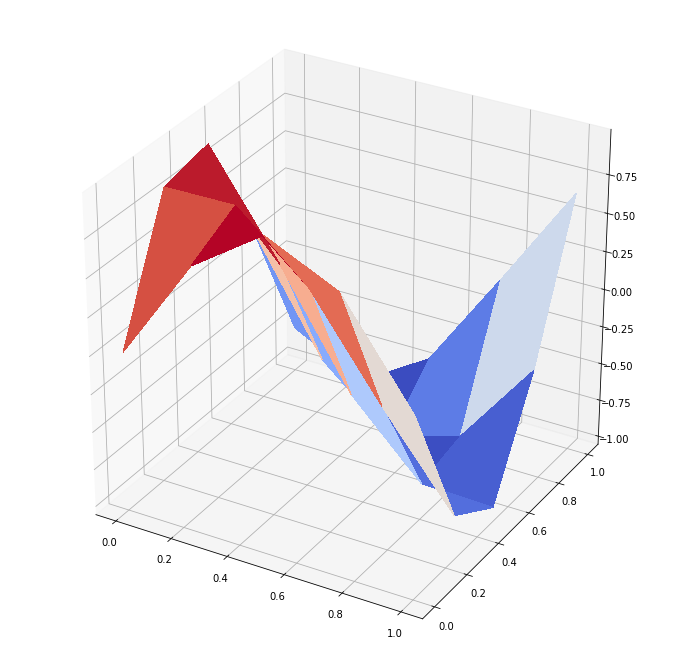

In [ ]:
# ---------- Part2 ----------
# solving the system

N = 4

A, b = helmholtz_wave(N)
x = spsolve(A, b)

u_h = compute_u_h(N, x)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
ticks = np.linspace(0, 1, N + 1)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u_h, antialiased=False, cmap=cm.coolwarm)
plt.show()

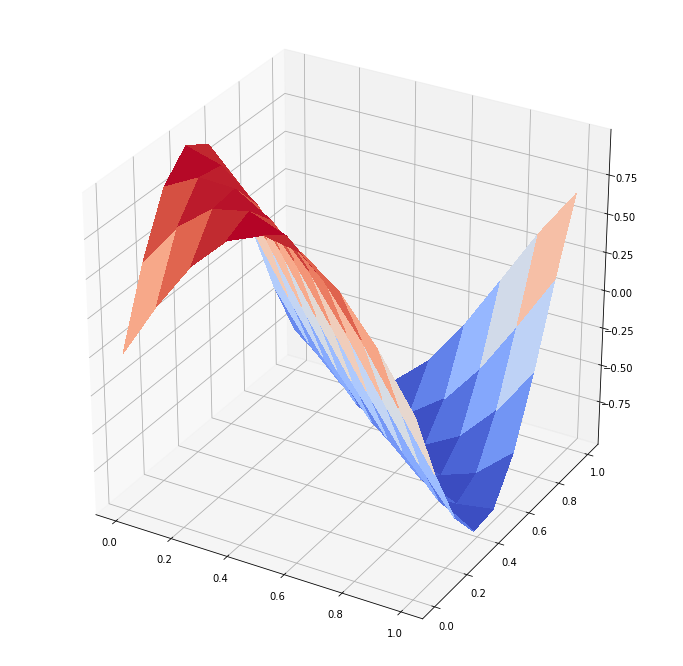

In [ ]:
N = 8

A, b = helmholtz_wave(N)
x = spsolve(A, b)

u_h = compute_u_h(N, x)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
ticks = np.linspace(0, 1, N + 1)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u_h, antialiased=False, cmap=cm.coolwarm)
plt.show()

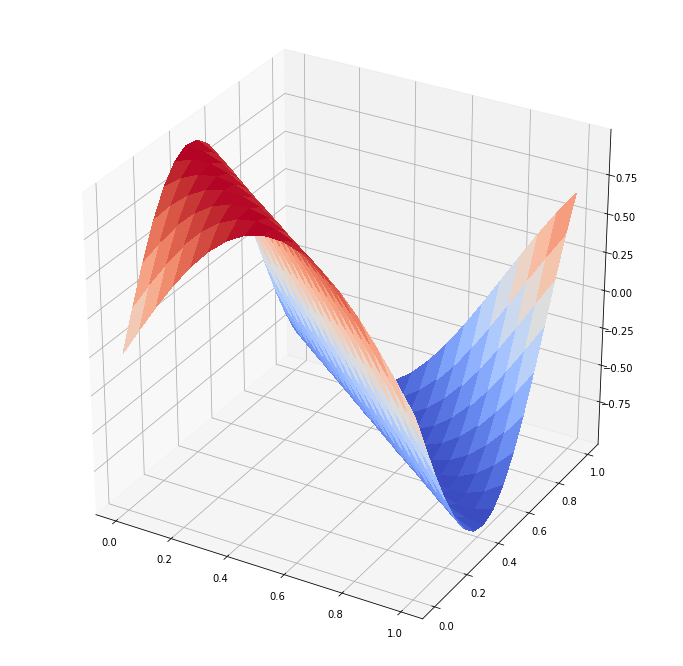

In [ ]:
N = 16

A, b = helmholtz_wave(N)
x = spsolve(A, b)

u_h = compute_u_h(N, x)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
ticks = np.linspace(0, 1, N + 1)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u_h, antialiased=False, cmap=cm.coolwarm)
plt.show()

**comparing solvers and preconditioners**

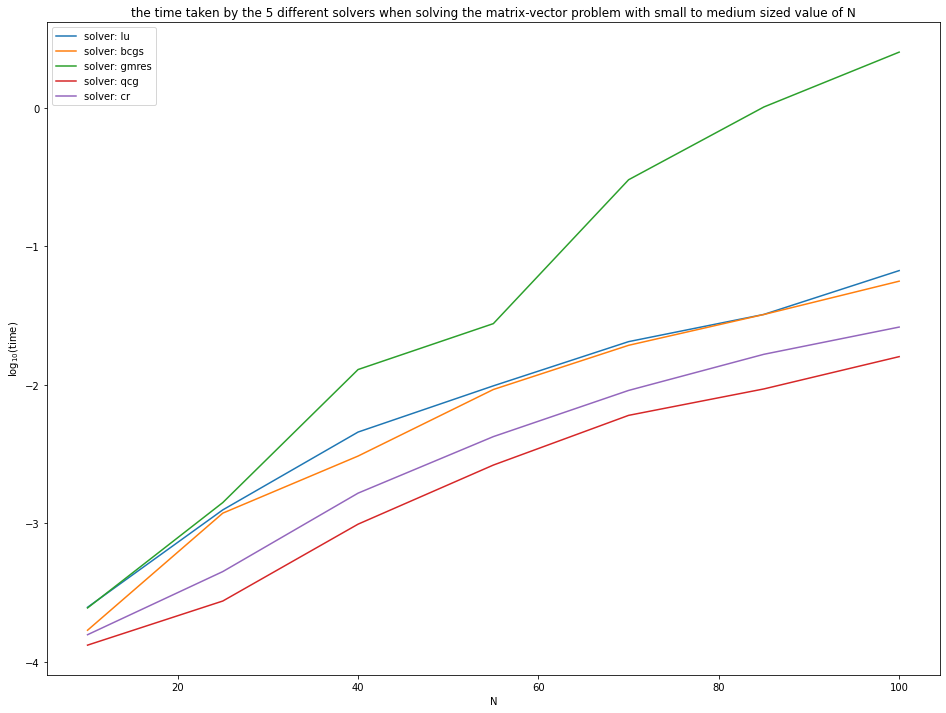

In [ ]:
# ---------- Part3 ----------
N_arr = np.arange(10,110,15)
solvers = ['lu', 'bcgs', 'gmres', 'qcg', 'cr']

plt.figure(figsize=(16, 12))
plt.xlabel("N")
# The time axis is set this way because the gmres method takes more time and is not in the same order of magnitude as the other methods
plt.ylabel('$\\log_{10}$(time)')
plt.title("the time taken by the 5 different solvers when solving the matrix-vector problem with small to medium sized value of N")
for i in range(len(solvers)):
    time_arr = []
    for N in N_arr:
        A_, b_ = helmholtz_wave(N)
        A = PETSc.Mat()
        A.createAIJ(size=A_.shape, csr=(A_.indptr, A_.indices, A_.data))
        ksp = PETSc.KSP().create()
        ksp.setOperators(A)
        x = A.createVecRight()
        b = A.createVecLeft()
        b.array[:] = b_
        # direct solver
        if solvers[i] == 'lu':
            ksp.setType('preonly')
            ksp.getPC().setType(solvers[i])
        # other solvers
        else:
            ksp.setType(solvers[i])
            ksp.getPC().setType('none')

        start_time = time.time()
        ksp.solve(b, x)
        end_time = time.time()
        time_arr.append(end_time - start_time)
    plt.plot(N_arr, np.log10(time_arr), label= 'solver: '+ solvers[i])
plt.legend()
plt.show()

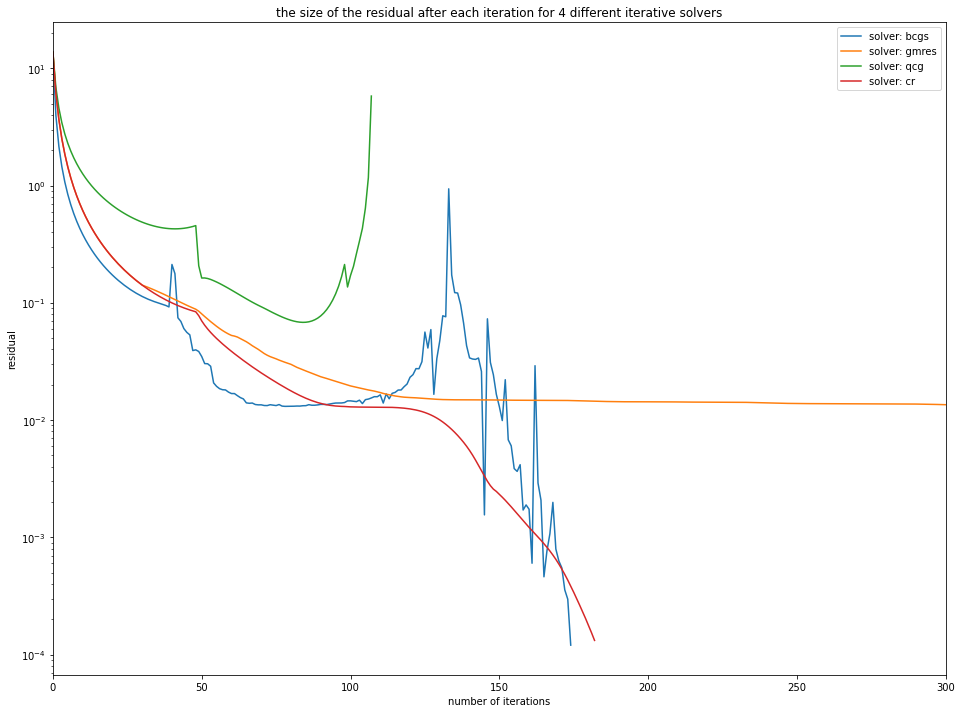

In [ ]:
plt.figure(figsize=(16, 12))
plt.xlabel("number of iterations")
plt.ylabel("residual")
plt.xlim(0, 300)
plt.title("the size of the residual after each iteration for 4 different iterative solvers")
solvers = ['lu', 'bcgs', 'gmres', 'qcg', 'cr']
for i in range(len(solvers[1:])):
    N = 100
    A_, b_ = helmholtz_wave(N)
    A = PETSc.Mat()
    A.createAIJ(size=A_.shape, csr=(A_.indptr, A_.indices, A_.data))
    ksp = PETSc.KSP().create()
    ksp.setOperators(A)
    x = A.createVecRight()
    b = A.createVecLeft()
    b.array[:] = b_
    ksp.setType(solvers[i + 1])
    ksp.setConvergenceHistory()
    ksp.getPC().setType('none')
    ksp.solve(b, x)
    plt.semilogy(ksp.getConvergenceHistory(), label= 'solver: '+ solvers[i + 1])
plt.legend()
plt.show()

I have plotted the figure of the time taken by the 5 different solvers when solving the matrix-vector problem with small to medium sized value of N and the figure of the size of the residual after each iteration for 4 different iterative solvers. For 5 different solvers, I use one direct solver lu and four iterative solvers which are bcgs, gmres, qcg and cr. By observing the figure of the variation of time with N, for all N values, taken times of 5 different solvers from most to least are gmres, lu, bcgs, cr and qcg. As N gets larger, the taken time of gmres solver is much more than other solvers. By observing the figure of the size of the residual after each iteration for 4 different iterative solvers, We found that the cr solver and the bcgs solver give small residuals when a certain iteration is reached. The residuals obtained by the cr solver decreased steadily without any fluctuations. The residuals obtained by the gmres solver did not decrease continuously with the number of iterations, and were less capable of solving the helmholtz wave problem than the two solvers mentioned above. The residuals obtained by the qcg solver decreased and then increased with the number of iterations increased, which is not a suitable solver for this problem. Taking into account the three factors of time, residuals and number of iterations, I chose **cr solver and bcgs solver** for the subsequent experiments.

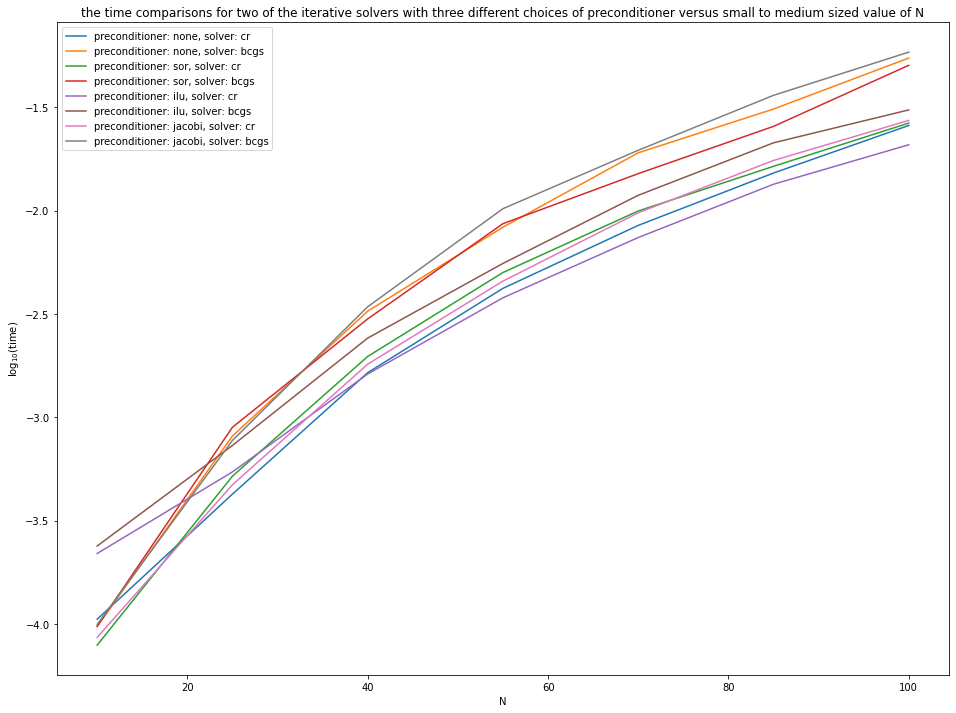

In [ ]:
N_arr = np.arange(10,110,15)
plt.figure(figsize=(16, 12))
plt.xlabel("N")
plt.ylabel('$\\log_{10}$(time)')
plt.title("the time comparisons for two of the iterative solvers with three different choices of preconditioner versus small to medium sized value of N")
preconditioners = ['none', 'sor', 'ilu', 'jacobi']
solvers = ['cr','bcgs']

for preconditioner in preconditioners:
    for solver in solvers:
        time_arr = []
        for N in N_arr:
            A_, b_ = helmholtz_wave(N)
            A = PETSc.Mat()
            A.createAIJ(size=A_.shape, csr=(A_.indptr, A_.indices, A_.data))
            ksp = PETSc.KSP().create()
            ksp.setOperators(A)
            x = A.createVecRight()
            b = A.createVecLeft()
            b.array[:] = b_
            ksp.setType(solver)
            ksp.getPC().setType(preconditioner)
            start_time = time.time()
            ksp.solve(b, x)
            end_time = time.time()
            time_arr.append(end_time - start_time)
        plt.plot(N_arr, np.log10(time_arr), label='preconditioner: ' + preconditioner + ', ' + 'solver: ' + solver)
plt.legend()
plt.show()

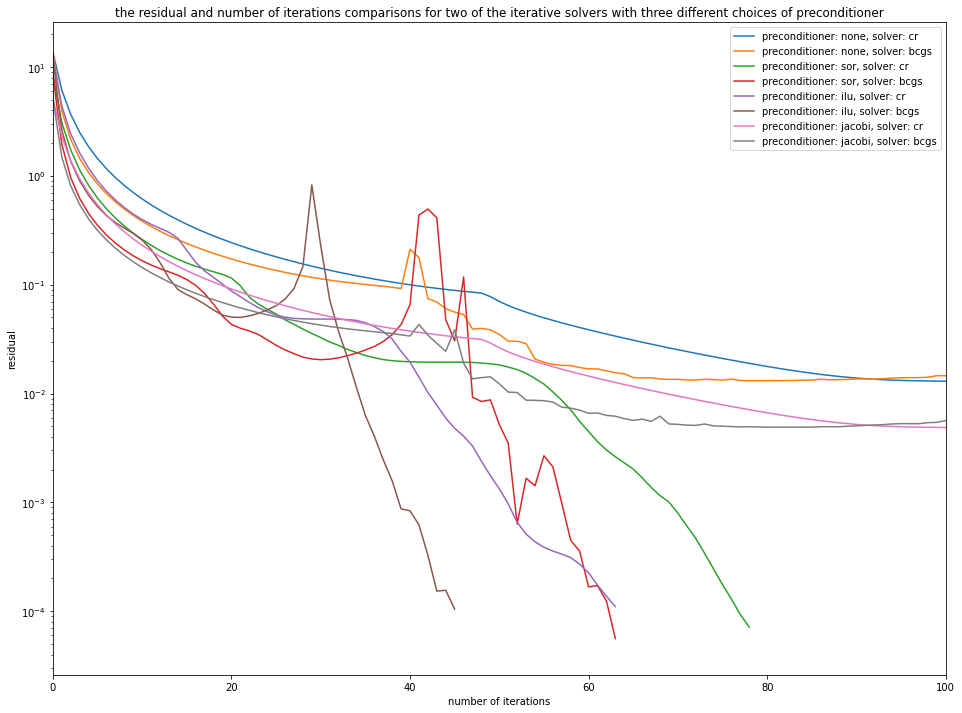

In [ ]:
plt.figure(figsize=(16, 12))
plt.xlabel("number of iterations")
plt.ylabel("residual")
plt.title("the residual and number of iterations comparisons for two of the iterative solvers with three different choices of preconditioner")
plt.xlim(0, 100)
preconditioners = ['none', 'sor', 'ilu', 'jacobi']
solvers = ['cr','bcgs']

for preconditioner in preconditioners:
    for solver in solvers:
        N = 100
        A_, b_ = helmholtz_wave(N)
        A = PETSc.Mat()
        A.createAIJ(size=A_.shape, csr=(A_.indptr, A_.indices, A_.data))
        ksp = PETSc.KSP().create()
        ksp.setOperators(A)
        x = A.createVecRight()
        b = A.createVecLeft()
        b.array[:] = b_
        ksp.setType(solver)
        ksp.setConvergenceHistory()
        ksp.getPC().setType(preconditioner)
        ksp.solve(b, x)
        plt.semilogy(ksp.getConvergenceHistory(), label='preconditioner: ' + preconditioner + ', ' + 'solver: ' + solver)
plt.legend()
plt.show()

I have plotted the figure of the time comparisons for two of the iterative solvers with three different choices of preconditioner versus small to medium sized value of N and the figure of the residual and number of iterations comparisons for two of the iterative solvers with three different choices of preconditioner. The two iterative solvers are cr and bcgs. The three choices of preconditioner are sor, ilu and jacobi. By observing the figure of the variation of time with N, some preconditioners can reduce the time spent by the solver. For example, to solve the problem, solver bcgs with preconditioner sor take less time than it without any preconditioner. And some preconditioners can increase the time spent by the solver. For example, to solve the problem, solver bcgs with preconditioner jacobi take less time than it without any preconditioner. In all combinations of preconditioner and solver, after increasing N to a certain range (N>40), when preconditioner is ilu and solver is cr, the taken time is the lowest. By observing the figure of the size of the residual after each iteration for different preconditioners and solvers combinations. We found that the cr solver with preconditioner sor, ilu and the bcgs solver with preconditioner sor, ilu give small residuals when a certain iteration is reached. The residuals obtained by the others' combinations did not decrease continous significantly with the number of iterations. For the four combinations can give small residuals when a certain iteration is reached,the bcgs solver with preconditioner ilu take the minimum number of iterations to achieve the same small residuals. Next in line are bcgs solver with preconditioner sor and cr solver with preconditioner ilu, which take a similar number of iterations, and finally is cr solver with preconditioner sor. On top of that, the residuals obtained by the cr solver with preconditioner sor, ilu decreased steadily without any fluctuations while the residuals obtained by the bcgs solver with preconditioner sor, ilu decreased unstably with fluctuations(the residuals increase in some range of iterations). Taking into account the three factors of time, residuals and number of iterations, I chose **cr solver with preconditioner ilu** for the subsequent experiments.

**For a range of values of N from small to large, compute the solution to the matrix-vector problem. Measure the time taken to compute this solution, and compute the error of the solution. Make plots showing the time taken and error as N is increased. Using your plots, estimate the complexity of the solver you are using and estimate the order of convergence of your solution.**

In part4, for the value of N, I started by setting the N interval to [10,1010], taking one value of N for every 100 intervals, but by looking at the figure below, we can find that the value of error has already not decreased (converge) when the value of N is smaller than 1000, so I set a smaller range of N interval to observe the change of error with N in the following.

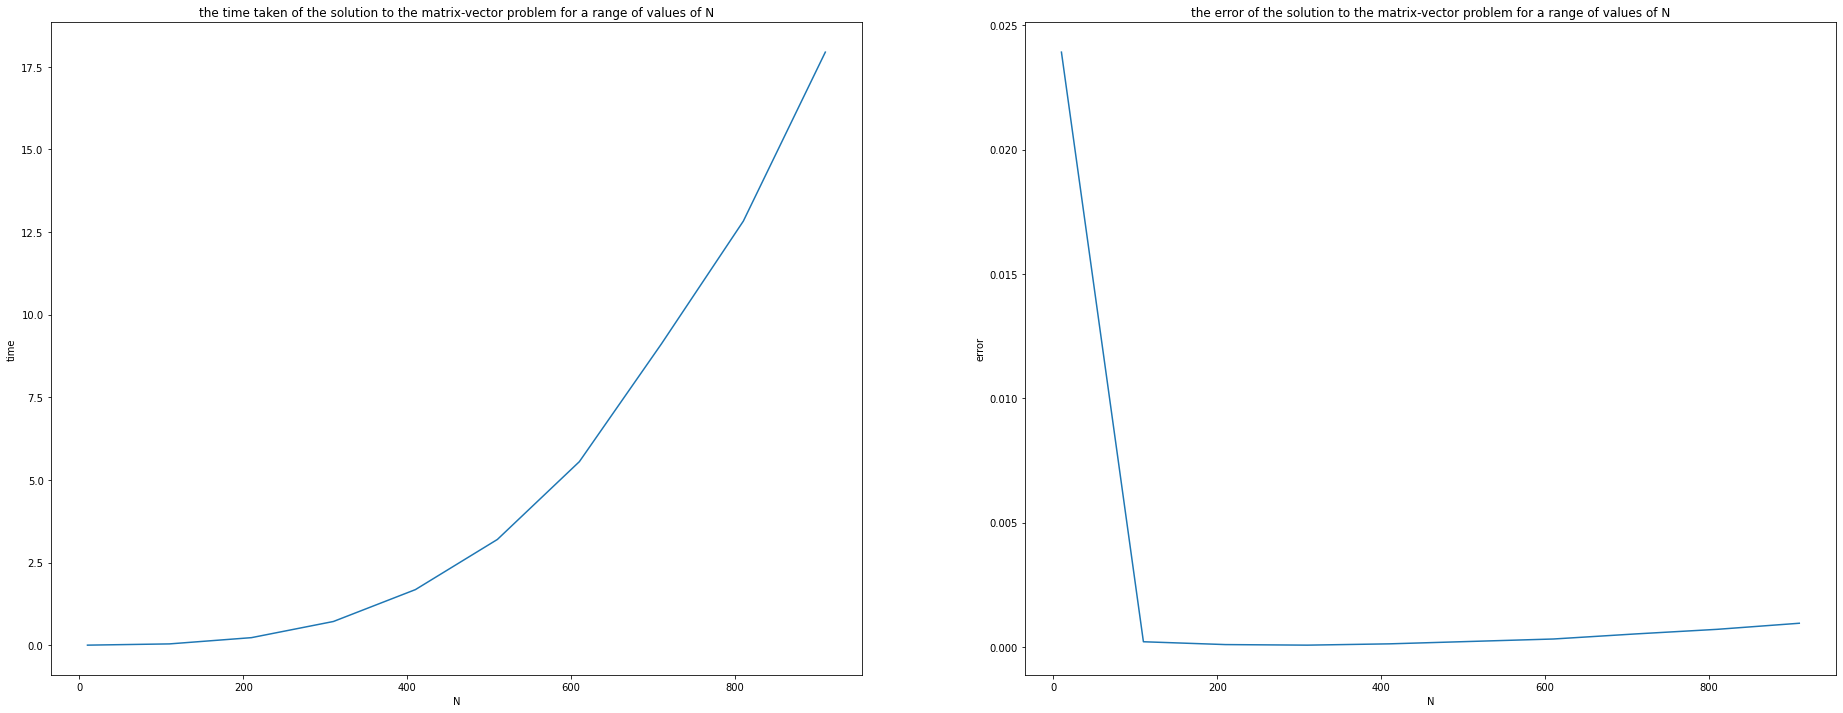

In [ ]:
# ---------- Part4 ----------
N_arr = np.arange(10,1010,100)
# picked preconditioner and solver
preconditioner = 'ilu'
solver = 'cr'

plt.figure(figsize=(32, 12))
time_arr = []
error_arr = []
for N in N_arr:
    A_, b_ = helmholtz_wave(N)
    A = PETSc.Mat()
    A.createAIJ(size=A_.shape, csr=(A_.indptr, A_.indices, A_.data))
    ksp = PETSc.KSP().create()
    ksp.setOperators(A)
    x = A.createVecRight()
    b = A.createVecLeft()
    b.array[:] = b_
    ksp.setType(solver)
    ksp.getPC().setType(preconditioner)
    start_time = time.time()
    ksp.solve(b, x)
    end_time = time.time()
    # calculate error
    h = 1 / N
    u_exact = compute_u_exact(N)
    u_h = compute_u_h(N, np.array(x))
    u_hm = compute_u_hm(N, u_h)
    error = np.sum(h ** 2 * np.abs(u_exact - u_hm))
    time_arr.append(end_time - start_time)
    error_arr.append(error)
plt.subplot(1, 2, 1)
plt.xlabel('N')
plt.ylabel('time')
plt.plot(N_arr, time_arr)
plt.title("the time taken of the solution to the matrix-vector problem for a range of values of N")
plt.subplot(1, 2, 2)
plt.xlabel('N')
plt.ylabel('error')
plt.plot(N_arr, error_arr)
plt.title("the error of the solution to the matrix-vector problem for a range of values of N")
plt.show()

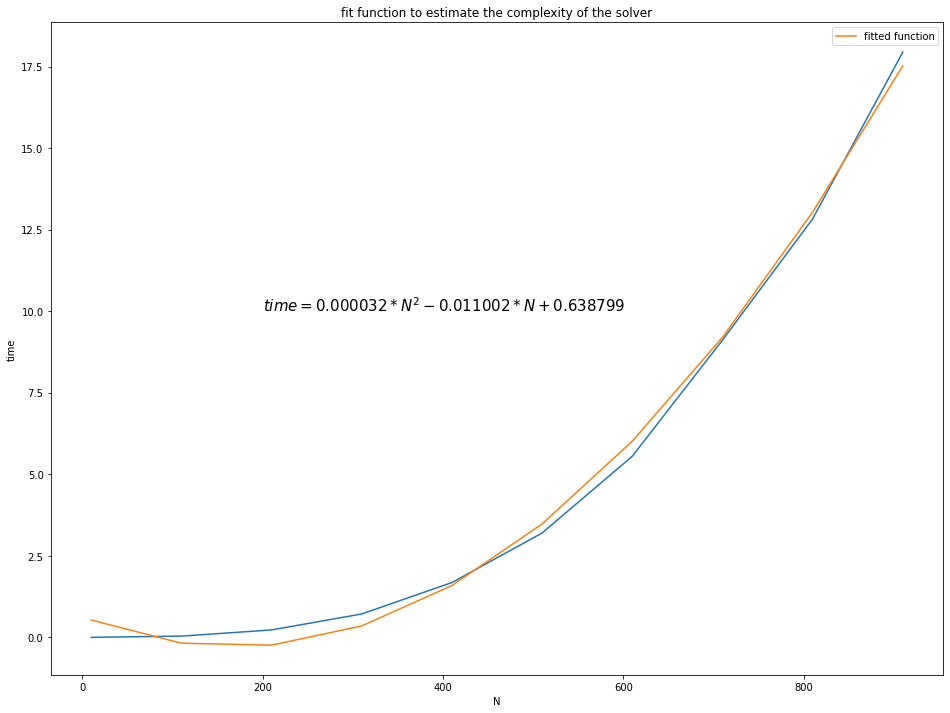

In [ ]:
# estimate the complexity of the solver I am using
p = np.polyfit(N_arr, time_arr, 2)
plt.figure(figsize=(16, 12))
plt.plot(N_arr, time_arr)
plt.plot(N_arr, p[0] * N_arr**2 + p[1] *N_arr + p[2] , label='fitted function')
plt.xlabel('N')
plt.ylabel('time')
plt.legend()
plt_text = '$time = %f * N^{2} %f*N + %f$' % (p[0], p[1], p[2])
plt.text(200, 10, plt_text, size=15)
plt.title("fit function to estimate the complexity of the solver")
plt.show()

estimate the complexity of the solver you are using:

Through the figure I have plotted of the time taken of the solution to the matrix-vector problem for a range of values of N. I found that the relationship between the y-value (time) and the x-value (N) is similar to that of a quadratic function, so I obtained the relationship between time and N by binary linear fitting as $time = 0.000032*N^{2} - 0.011002*N + 0.638799$. If you look at the figure above, you can see that the function we fit matches the reality function very closely. Based on this result, we can know the complexity of the solver I am using is O($N^{2}$).




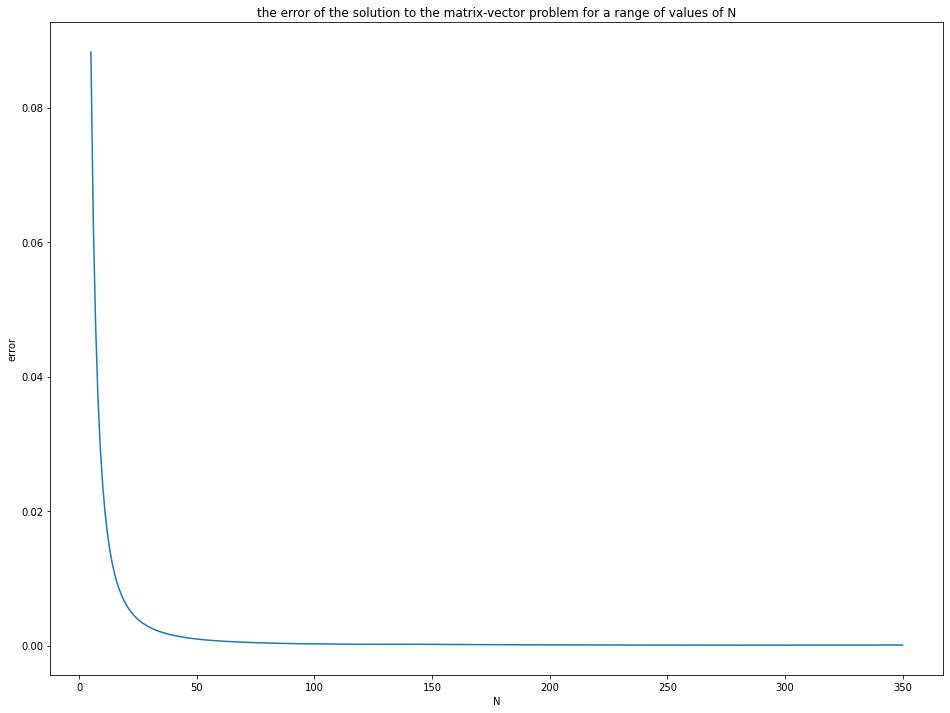

In [ ]:
# define the new interval of N to observing the change of error with N
N_arr = np.arange(5,351)
preconditioner = 'ilu'
solver = 'cr'

plt.figure(figsize=(16, 12))
time_arr = []
error_arr = []
for N in N_arr:
    A_, b_ = helmholtz_wave(N)
    A = PETSc.Mat()
    A.createAIJ(size=A_.shape, csr=(A_.indptr, A_.indices, A_.data))
    ksp = PETSc.KSP().create()
    ksp.setOperators(A)
    x = A.createVecRight()
    b = A.createVecLeft()
    b.array[:] = b_
    ksp.setType(solver)
    ksp.getPC().setType(preconditioner)
    ksp.solve(b, x)
    # calculate error
    h = 1 / N
    u_exact = compute_u_exact(N)
    u_h = compute_u_h(N, np.array(x))
    u_hm = compute_u_hm(N, u_h)
    error = np.sum(h ** 2 * np.abs(u_exact - u_hm))
    error_arr.append(error)
    # print(error)
plt.xlabel('N')
plt.ylabel('error')
plt.plot(N_arr, error_arr)
# plt.semilogy(N_arr, error_arr)
plt.title("the error of the solution to the matrix-vector problem for a range of values of N")
plt.show()

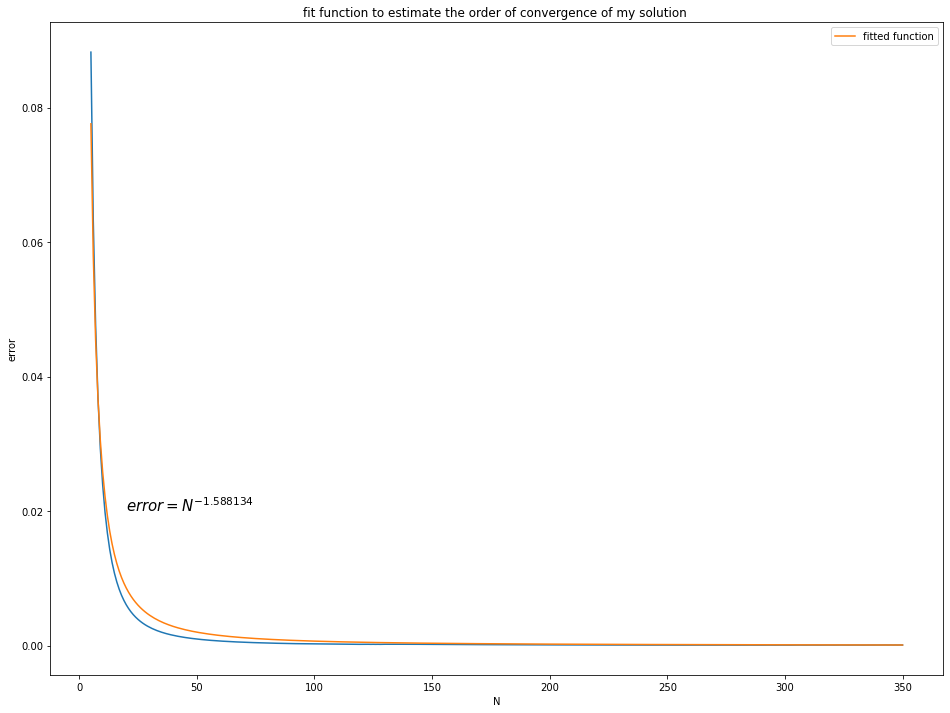

In [ ]:
# estimate the order of convergence of my solution
popt, pcov = curve_fit(power_fit, N_arr, error_arr)
y_fit = [power_fit(i, popt[0]) for i in N_arr]
plt.figure(figsize=(16, 12))
plt.plot(N_arr, error_arr)
plt.plot(N_arr, y_fit, label='fitted function')
plt.xlabel('N')
plt.ylabel('error')
plt.legend()
plt_text = '$error = N^{-%f}$' % (popt[0])
plt.text(20, 0.02, plt_text, size=15)
plt.title("fit function to estimate the order of convergence of my solution ")
plt.show()

estimate the order of convergence of your solution:

Through the figure I have plotted of the error of the solution to the matrix-vector problem for a range of values of N. I found that the relationship between the y-value (error) and the x-value (N) is similar to $N^{-α}$, so I obtained the relationship between error and N by power curve fitting as $error = N^{-1.588}$. If you look at the figure above, you can see that the function we fit matches the reality function very closely. By analysing the fit function and combining it with the figure we plotted, we can conclude that the value of error decreases rapidly as N increases when N is in a small value interval(for my figure is [5,35]), but when N reaches a certain value, the value of error hardly decreases anymore and our solution method converges best. The figure below will find find more precisely when N is what value, our method converges best.

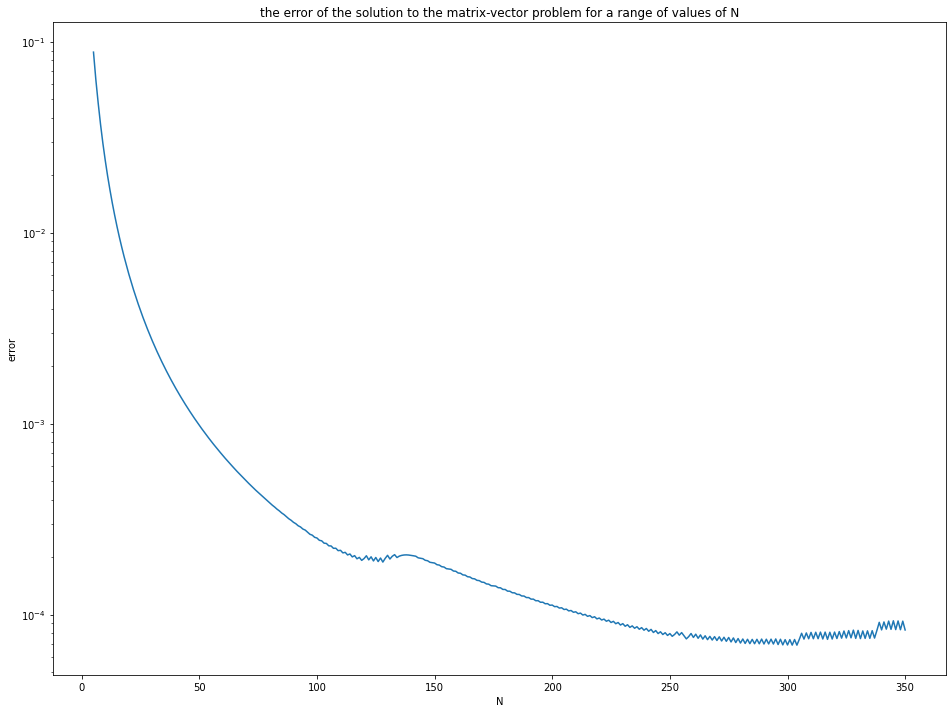

In [ ]:
# Using plot.semilogy() to plot figure to find more precisely when N is what value, our method converges best
plt.figure(figsize=(16, 12))
plt.xlabel('N')
plt.ylabel('error')
plt.semilogy(N_arr, error_arr)
plt.title("the error of the solution to the matrix-vector problem for a range of values of N")
plt.show()

This figure gives a more clear y-axis value (error) and we can conclude that our solution converges best when N is close to 300 and the error reaches its minimum value(if you uncomment my print function, you can observe and get the minimum error value is nearly $6.9278891575853e^{-05}$). At this point N gives the closest approximation to the true solution obtained by our finite element method(solver Conjugate Residual, preconditioner Incomplete LU).

**Comment on how your solution method could be parallelised. If in part 4 you used a solver that we have not studied in lectures, you can discuss different solvers in parts 4 and 5.**

Let me briefly discuss the solver I use, which is Conjugate residual.

The conjugate residual method is a Krylov subspace method, which is very similar to the familiar conjugate gradient method and has similar construction and convergence properties. In contrast to the conjugate gradient method, the system matrix of the conjugate residual method is only required to be Hermitian, not Hermitian positive definite. Conjugate residual method is less restrictive.

Given an (arbitrary) initial estimate of the solution $x_0$, the method is outlined below:


$x_0$ := Some initial guess

$r_0 := b - Ax_0$

$p_0:= r_0$

Iterate, with k starting at 0:

$α_k:= r_k^{T}Ar_k / (Ap_k)^{T} Ap_k$

$x_{k+1}:= x_k + α_kp_k$

$r_{k+1}:= r_k - α_kAp_k$

$β_k:= r_{k+1}^{T}Ar_{k+1} / r_{k}^{T}Ar_{k}$

$p_{k+1}:= r_{k+1} + β_kp_k$

$Ap_{k+1}:= Ar_{k+1} + β_kAp_k$

$k:= k+1$

formula from Wikipedia contributors. (2022, October 17). Conjugate residual method. Wikipedia. https://en.wikipedia.org/wiki/Conjugate_residual_method

Parallelisation

My understanding of parallelism is that if these threads can be parallelized, then the tasks done by each thread cannot be subject to other threads. And programs that involve results that change over time cannot be assigned to multiple threads for parallel execution, because time is always moving forward, and it would be paradoxical if tasks that change over time could be parallelized.

So for our entire solution the assignment operations to the A matrix and the b vector can be parallelised. Because the value assigned to each point depends on the value of N and the coordinates of the point, the values of the points are not constrained directly to each other. The parallelism is achieved by replacing the for loop in the code of the assignment functions of A matrix and b vector. Because the computations in the for loops are not dependent on each other (in this case what for loop do is to assign values to the elements (points) in the matrix  in order of index), that is, each loop just concentrates on its own thing and the ith loop does not affect the computation of the jth loop, we put such mutually independent for loops into a CUDA thread to do parallel computation.

For the conjugate residue solver I have chosen, it is an iterative solver. Combined with the formula of the whole solver I have shown above, we can see that each iteration uses the result of the previous iteration, this iteration is done in chronological order. Although you can set a judgement condition, the so-called parallelism will also has the same effect as not parallelism(it would be paradoxical if tasks that change over time could be parallelized), not a true parallelism. So for the solver part, as far as I understand it, there is no way to reduce the runtime by parallelise.

If not parallelism, for matrix and vector assignments, we need to execute loop for loop size's times (In my code is $(N-1)^2$ times). After parallelisation, each loop does the task at the same time, and in the best case the time spent is as if only one loop of the original had been executed, so the time spent on the parallelism for assignment value of matrix and vector I expected is equal to the original time divided by the loop size. Solver part I have no parallelism and the time spent is unchanged.